# Cascading Failure Model

Lets first create a network, assign random capacities and loads to the nodes, then simulate a cascading failure event initiated by an overloaded node.

Lets start with a simple Erdos-Renyi graph for the infrastructure network.  The nodes of the graph have randomly assigned loads and capacities. Then, it introduces a failure by overloading a node. If a node's load exceeds its capacity, it will 'fail' and its load will be redistributed among its neighbors. This can cause subsequent failures, leading to a cascading effect. The simulate_cascading_failure function continues this process until there are no overloaded nodes left.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import random


**Initialize_network(num_nodes)**: function initializes a network with a specified number of nodes. It uses the Erdos-Renyi model to generate the graph. The Erdos-Renyi model is a random graph generation model that generates a graph of 'num_nodes' nodes, and each pair of nodes is connected with a probability of 0.5. For each node in the graph, it assigns a capacity, a load, and a state. The capacity and load are randomly generated numbers, with the load potentially being higher to increase the chance of node failure. The state of the node is determined by whether its load is less than its capacity (in which case it's 'alive') or not (in which case it's 'dead').

In [25]:
def initialize_network(num_nodes):
    """
    Initializes a network with a specified number of nodes.
    Each node is assigned a random capacity and a random load.
    Now, load is made heavier than capacity to increase chances of failure.
    """
    G = nx.erdos_renyi_graph(num_nodes, 0.5)
    for i in range(num_nodes):
        G.nodes[i]['capacity'] = random.uniform(0, 10)
        G.nodes[i]['load'] = random.uniform(0, 10)  # Increase maximum possible load
        G.nodes[i]['state'] = 'alive' if G.nodes[i]['load'] < G.nodes[i]['capacity'] else 'dead'
    return G

**Redistribute_load(G, node)**: This function redistributes the load of a given node to its neighbors if the node is 'alive'. If the node is 'dead', nothing happens. If the node has neighbors, it equally divides its load among them. Finally, it changes the state of the node to 'dead'.

In [16]:
def redistribute_load(G, node):
    """
    Redistributes the load of a node to its neighbors and changes its state to 'dead'.
    """
    if G.nodes[node]['state'] == 'dead':
        return
    neighbors = list(G.neighbors(node))
    if neighbors: # Only redistribute load if there are neighbors
        extra_load = G.nodes[node]['load'] / len(neighbors)
        for neighbor in neighbors:
            if G.nodes[neighbor]['state'] == 'alive':
                G.nodes[neighbor]['load'] += extra_load
    G.nodes[node]['state'] = 'dead'

**Simulate_cascading_failure(G)**: This function simulates a cascading failure event in the network. It identifies nodes that are overloaded (their load is greater than their capacity and they are 'alive') and redistributes their load among their neighbors using the redistribute_load(G, node) function, as defined above. This process repeats until there are no more overloaded nodes.

Since, the loop continues until there are no overloaded nodes left in the network - i.e., all nodes that had a load greater than their capacity have already failed and redistributed their load. This process is intrinsic to the problem's nature: the cascading failure continues until there are no further failures. Therefore, we can't explicitly set the number of time steps, as the simulation's duration depends on the network's initial conditions and how the failures propagate.

In [35]:
def simulate_cascading_failure(G):
    """
    Simulates a cascading failure event in a network.
    Nodes with a load greater than their capacity will fail and their load will be redistributed.
    
    Returns a list of dictionaries that contains the count of 'alive' and 'dead' nodes at each time step
    """
    num_nodes = G.number_of_nodes()
    counts = []
    while True:
        overloaded_nodes = [i for i in range(num_nodes) if G.nodes[i]['load'] > G.nodes[i]['capacity'] and G.nodes[i]['state'] == 'alive']
        counts.append({'alive': sum([1 for node in G.nodes if G.nodes[node]['state'] == 'alive']), 
                       'dead': sum([1 for node in G.nodes if G.nodes[node]['state'] == 'dead'])})
        if not overloaded_nodes:
            break
        for node in overloaded_nodes:
            redistribute_load(G, node)
    return counts          

**Check_most_impactful_node(num_nodes)**: This function finds the node that, when overloaded, leads to the most failures in the network. It iteratively overloads each node, simulates the cascading failure, and counts the number of 'dead' nodes. If overloading a node results in more failures than the current maximum, that node is marked as the most impactful, and the process continues until all nodes have been tested.

In [18]:
def check_most_impactful_node(num_nodes):
    """
    Checks which node, when overloaded, leads to the most failures in the network.
    """
    max_failures = 0
    max_failure_node = None
    for i in range(num_nodes):
        G = initialize_network(num_nodes)
        G.nodes[i]['load'] = G.nodes[i]['capacity'] + 1  # Overload this node
        simulate_cascading_failure(G)
        num_failures = sum([1 for node in G.nodes if G.nodes[node]['state'] == 'dead'])
        if num_failures > max_failures:
            max_failures = num_failures
            max_failure_node = i
    print(f"Node {max_failure_node} causes the most failures when overloaded, with {max_failures} total failures.")


**Plot_network(G)**: This function plots the network, coloring nodes based on their state. 'Alive' nodes are colored green, and 'dead' nodes are colored red. This provides a visual representation of the state of the network.

In [28]:
def plot_network(G, ax):
    """
    Plots the network with nodes colored based on their state.
    Alive nodes are green, dead nodes are red.
    """
    colors = ['green' if G.nodes[i]['state'] == 'alive' else 'red' for i in range(G.number_of_nodes())]
    nx.draw(G, node_color=colors, ax=ax)

**Results**:

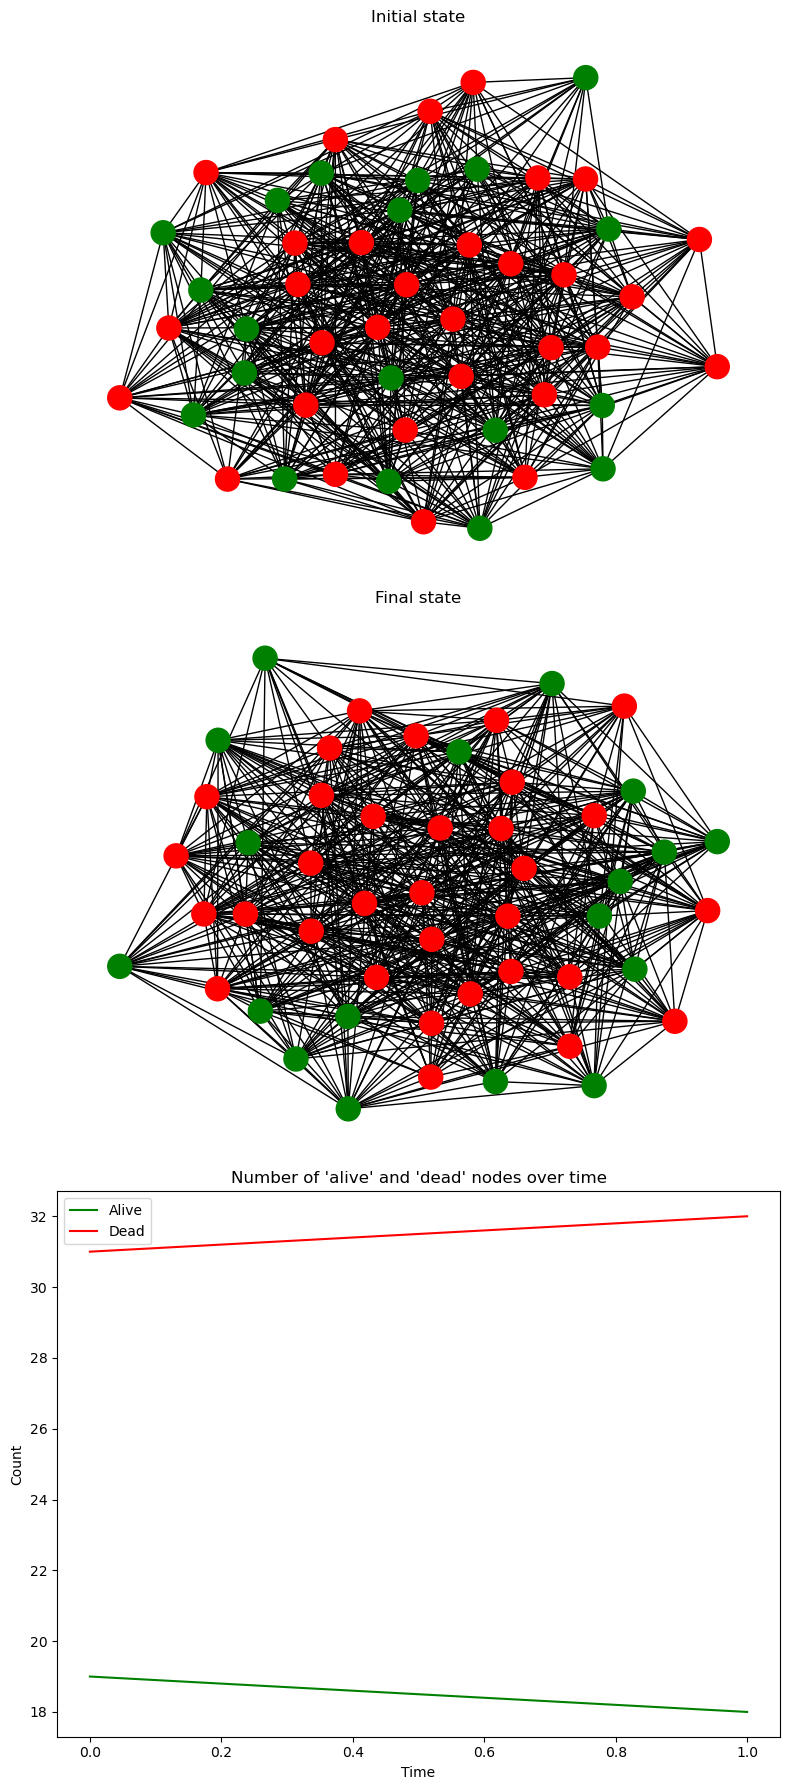

Node 19 causes the most failures when overloaded, with 35 total failures.


In [29]:
num_nodes = 50
G = initialize_network(num_nodes)

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

# Plot initial state
axs[0].set_title('Initial state')
plot_network(G, axs[0])

# Introduce a failure by overloading a node
overloaded_node = random.randint(0, num_nodes - 1)
G.nodes[overloaded_node]['load'] = G.nodes[overloaded_node]['capacity'] + 1

# Simulate cascading failure and get counts of 'alive' and 'dead' nodes
counts = simulate_cascading_failure(G)

# Plot final state
axs[1].set_title('Final state')
plot_network(G, axs[1])

# Plot number of 'alive' and 'dead' nodes over time
times = list(range(len(counts)))
alive_counts = [count['alive'] for count in counts]
dead_counts = [count['dead'] for count in counts]
axs[2].plot(times, alive_counts, color='green', label='Alive')
axs[2].plot(times, dead_counts, color='red', label='Dead')
axs[2].set_title('Number of \'alive\' and \'dead\' nodes over time')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Count')
axs[2].legend()

plt.tight_layout()
plt.show()

# Check most impactful node
check_most_impactful_node(num_nodes)


## Points to Remember:
The cascading failure model you have is determined by a number of factors, such as:

- Network topology: The graph structure (how nodes are connected to each other) can significantly affect the propagation of cascading failures. For instance, in a highly interconnected graph, a failure can rapidly propagate through many paths. Conversely, in a less connected graph, a failure may affect fewer nodes.

- Initial load and capacity of nodes: In your model, each node has a random load and capacity. The ratio between the average load and average capacity in the network can impact the likelihood of cascading failures. If you increase the average load (or decrease the average capacity), nodes are more likely to be overloaded, triggering more cascading failures.

- Distribution of load and capacity: Besides average load and capacity, the way these quantities are distributed also matters. If some nodes have very high capacity and others very low, the high capacity nodes might "protect" the network by absorbing a lot of load without failing.

# Role of Network Topology in Cascading Failure


let's compare how different network topologies affect the cascading failures. We'll keep the same load and capacity distributions for each graph, but change the topology. 
In particular, we'll compare:

- An **Erdős–Rényi random graph**, where each pair of nodes is connected with the same probability. 
- A scale-free network (**barabasi_albert_graph**), which has a few highly connected nodes.

We have already used the Erdős–Rényi graph in your previous simulation. Let's add the scale-free network to the comparison. NetworkX provides a function nx.barabasi_albert_graph to generate a scale-free network. This model uses preferential attachment, meaning that more connected nodes are more likely to receive new links.

A function to initialize a scale-free network with a given number of nodes. It is similar function as we have before, we just added barabasi_albert_graph instead of Erdős–Rényi random graph in pace of graph.

In [40]:
def initialize_scale_free_network(num_nodes):
    """
    Initializes a scale-free network with a specified number of nodes.
    Each node is assigned a random capacity and a random load.
    """
    G = nx.barabasi_albert_graph(num_nodes, 2)  # 2 is the number of edges to attach from a new node to existing nodes
    for i in range(num_nodes):
        G.nodes[i]['capacity'] = random.uniform(0, 10)
        G.nodes[i]['load'] = random.uniform(0, 15)  # Increase maximum possible load
        G.nodes[i]['state'] = 'alive' if G.nodes[i]['load'] < G.nodes[i]['capacity'] else 'dead'
    return G


Now, let's simulate the cascading failure for both network topologies and compare the results.

In [33]:
# Erdos-Renyi graph
num_nodes = 50
G_er = initialize_network(num_nodes)
overloaded_node = random.randint(0, num_nodes - 1)
G_er.nodes[overloaded_node]['load'] = G_er.nodes[overloaded_node]['capacity'] + 1
simulate_cascading_failure(G_er)
num_failures_er = sum([1 for node in G_er.nodes if G_er.nodes[node]['state'] == 'dead'])

# Scale-free network
G_sf = initialize_scale_free_network(num_nodes)
overloaded_node = random.randint(0, num_nodes - 1)
G_sf.nodes[overloaded_node]['load'] = G_sf.nodes[overloaded_node]['capacity'] + 1
simulate_cascading_failure(G_sf)
num_failures_sf = sum([1 for node in G_sf.nodes if G_sf.nodes[node]['state'] == 'dead'])

print(f"In the Erdos-Renyi graph, there were {num_failures_er} total failures.")
print(f"In the scale-free network, there were {num_failures_sf} total failures.")


In the Erdos-Renyi graph, there were 22 total failures.
In the scale-free network, there were 37 total failures.


The cabove code will print the total number of failures (nodes that end up 'dead') in each graph. By comparing these numbers, you can get an idea of how the network topology affects the propagation of cascading failures.

Bear in mind that the results of this simulation can be quite variable due to the randomness in the initial load and capacity assignments, as well as the initial overloaded node. To get a more reliable comparison, you could repeat the simulation multiple times and average the results.